<a href="https://colab.research.google.com/github/JyotikaJayani-08/Ambu-Trackers-/blob/main/AirQualityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.2 MB/s eta 0:00:00


Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib

Loading the dataset

In [ ]:
  !pip install chardet
  import chardet

  with open("/content/global air pollution dataset.csv", "rb") as f:
      encoding = chardet.detect(f.read())["encoding"]

  df = pd.read_csv("/content/global air pollution dataset.csv", encoding=encoding)

Mean Median calculation


In [ ]:
mean_aqi = df[["AQI Value", "CO AQI Value", "Ozone AQI Value", "NO2 AQI Value", "PM2.5 AQI Value"]].mean()

print("Average (Mean) AQI Values:")
print(mean_aqi)


Average (Mean) AQI Values:
AQI Value          72.010868
CO AQI Value        1.368367
Ozone AQI Value    35.193709
NO2 AQI Value       3.063334
PM2.5 AQI Value    68.519755
dtype: float64


Visualising the dataset

In [ ]:
df.head()

Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2               Italy   Priolo Gargallo         66     Moderate             1   
3              Poland         Przasnysz         34         Good             1   
4              France          Punaauia         22         Good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            Good               36               Good              0   
1            Good                5               Good              1   
2            Good               39               Good              2   
3            Good               34               Good              0   
4            Good               22               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
0             Good               51           Moderate  
1             Good               41               Good  
2             Good               66           Moderate  
3             Good               20               Good  
4             Good                6               Good

Median and Mean calculation


In [ ]:


# Calculating median AQI values
median_aqi = df[["AQI Value", "CO AQI Value", "Ozone AQI Value", "NO2 AQI Value", "PM2.5 AQI Value"]].median()

print("Median AQI Values:")
print(median_aqi)


Median AQI Values:
AQI Value          55.0
CO AQI Value        1.0
Ozone AQI Value    31.0
NO2 AQI Value       1.0
PM2.5 AQI Value    54.0
dtype: float64


Checking null values and dropping them

In [ ]:

df = df.dropna()

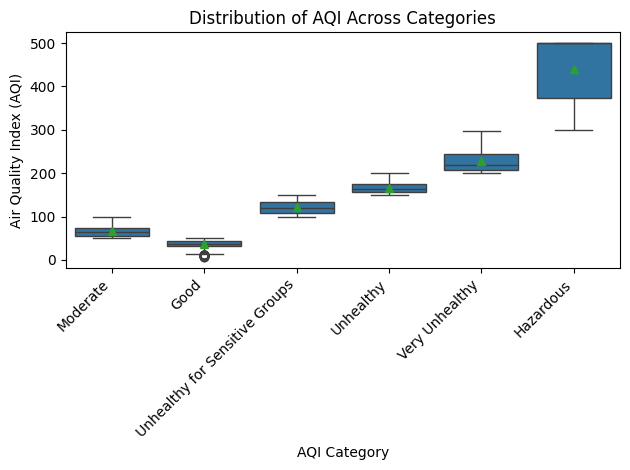

In [ ]:
sns.boxplot(
    x = "AQI Category",
    y = "AQI Value",
    showmeans=True,
    data=df
)
plt.xlabel("AQI Category")
plt.ylabel("Air Quality Index (AQI)")
plt.title("Distribution of AQI Across Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


 Encode categorical variables


In [ ]:

label_encoders = {}
categorical_cols = ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:

# Select only numeric columns for correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


Plotting Correlation heatmap


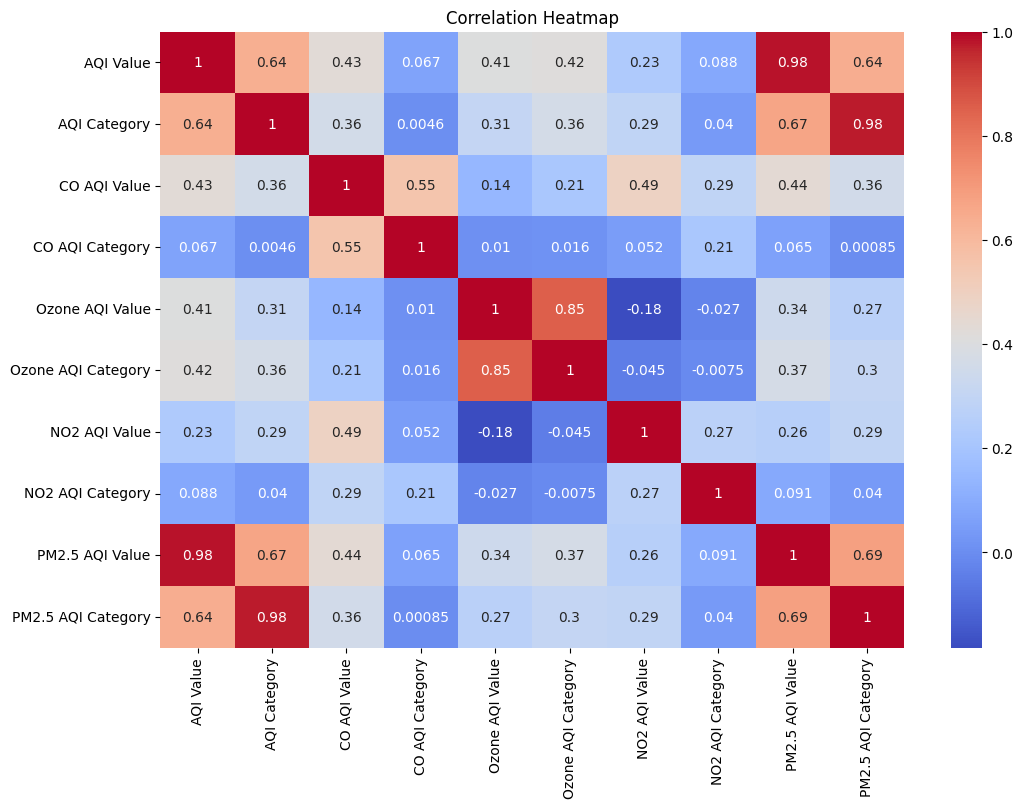

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



Split data into features and target


In [ ]:

features_to_use = ['PM2.5 AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value',
                   'AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']
X = df[features_to_use]
y = df['AQI Value']

Create a pipeline for preprocessing


In [ ]:

numeric_features = ['PM2.5 AQI Value', 'Ozone AQI Value', 'CO AQI Value', 'NO2 AQI Value']
categorical_features = ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']


In [ ]:

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])


In [ ]:

X_processed = preprocessor.fit_transform(X)

Splitting into train and test

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



Training Model

In [ ]:

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

Mean Squared Error: 9.131835359235945
R-squared: 0.9972596461675365


In [ ]:
# GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
# Get the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
# Make predictions
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:

print(f'Best parameters: {best_params}')
print(f'Best Model Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Mean Squared Error: 8.826287648305525
R-squared: 0.997351337356406


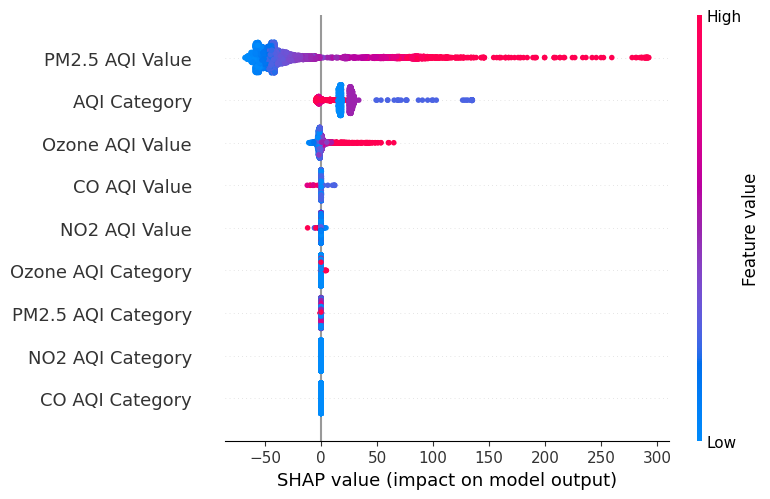

In [ ]:
# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=numeric_features + categorical_features)


Residual Analysis

In [ ]:

# Residual Analysis
residuals = y_test - y_pred

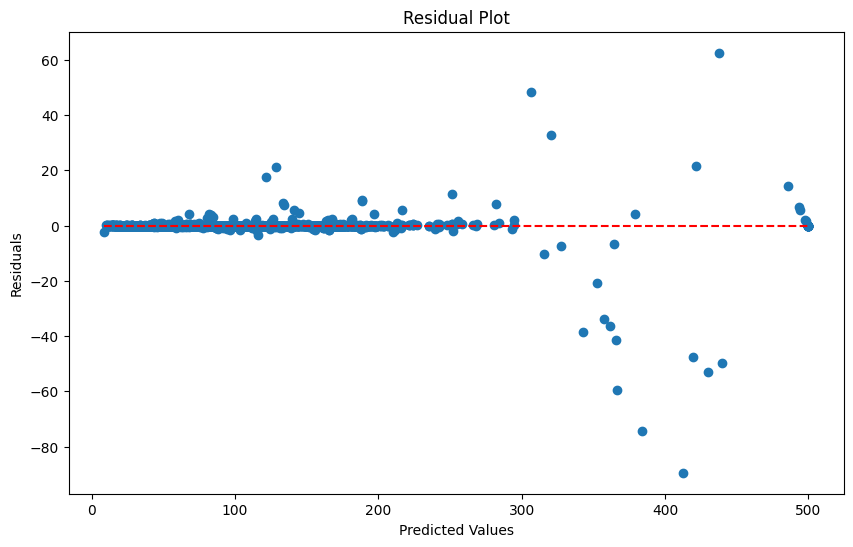

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


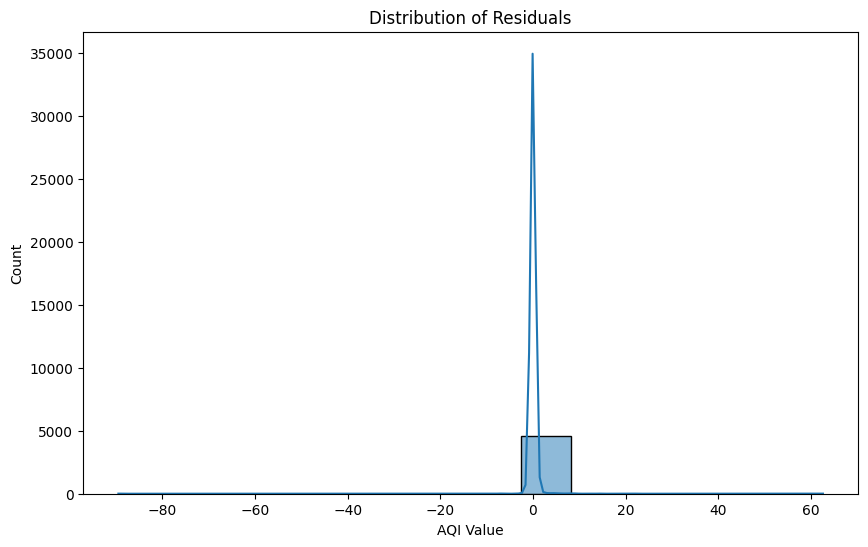

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()


In [ ]:
# Save the model
joblib.dump(best_model, 'best_random_forest_model.pkl')


['best_random_forest_model.pkl']

EDA Analysis by various Plots

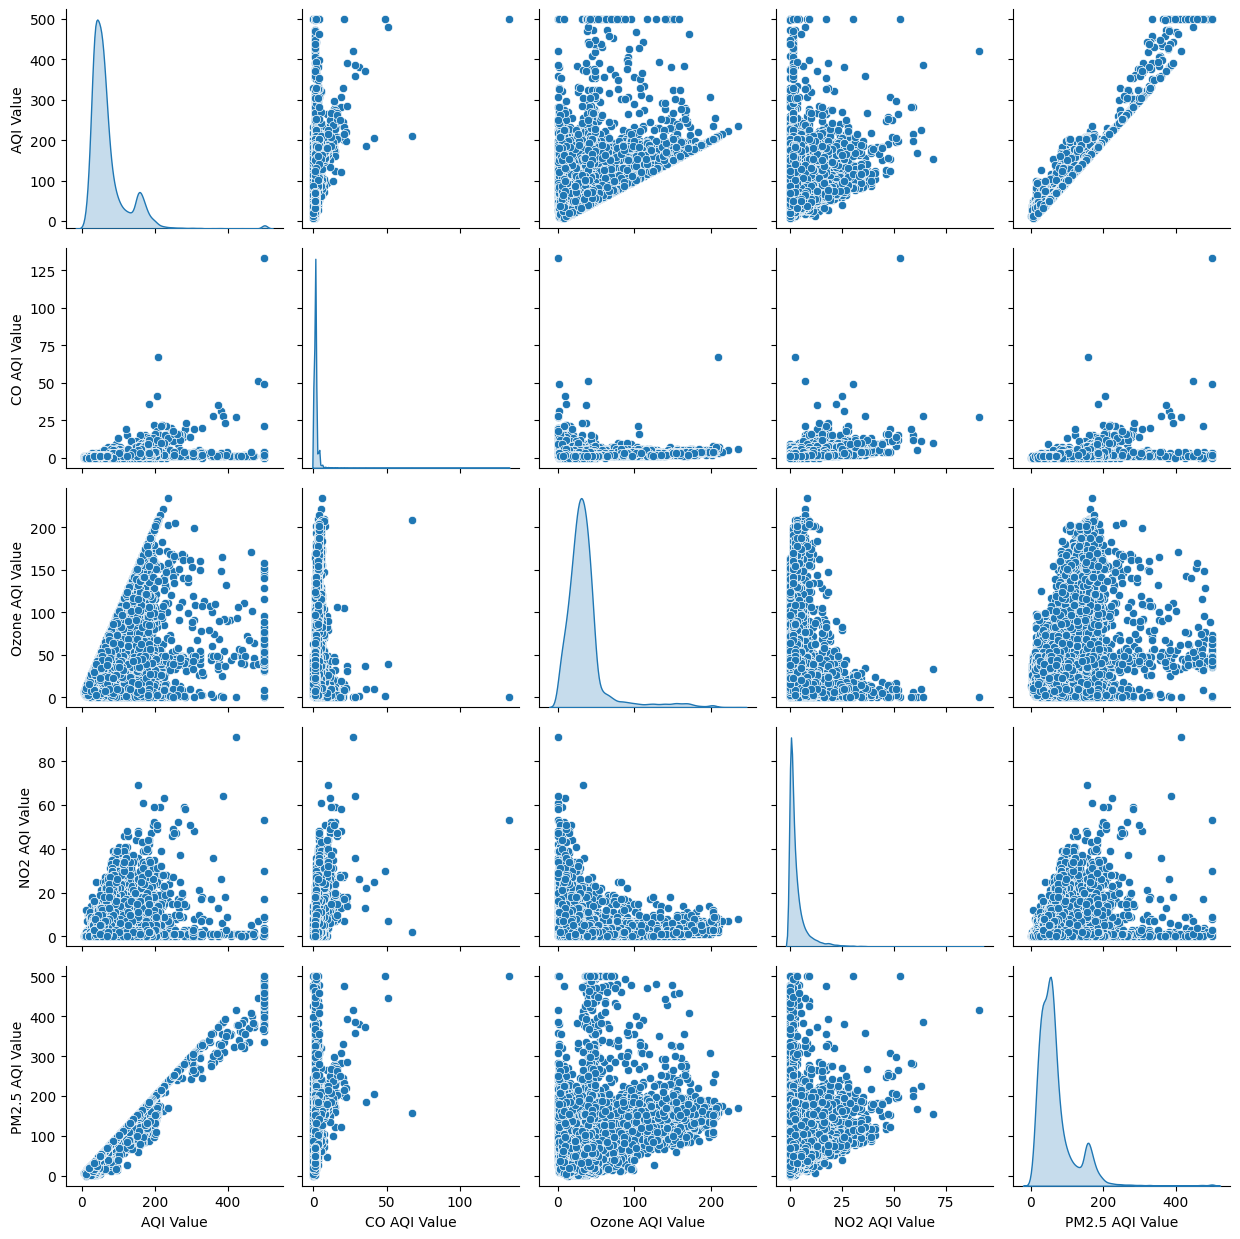

In [ ]:
sns.pairplot(df[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']], diag_kind="kde")
plt.tight_layout()
plt.show()

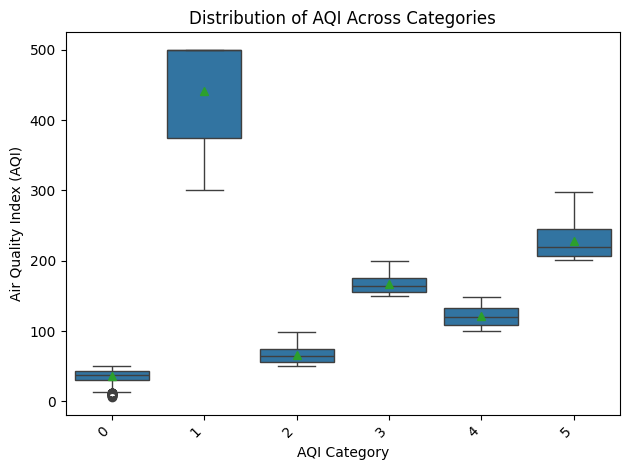

In [ ]:
sns.boxplot(
    x = "AQI Category",
    y = "AQI Value",
    showmeans=True,
    data=df
)
plt.xlabel("AQI Category")
plt.ylabel("Air Quality Index (AQI)")
plt.title("Distribution of AQI Across Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


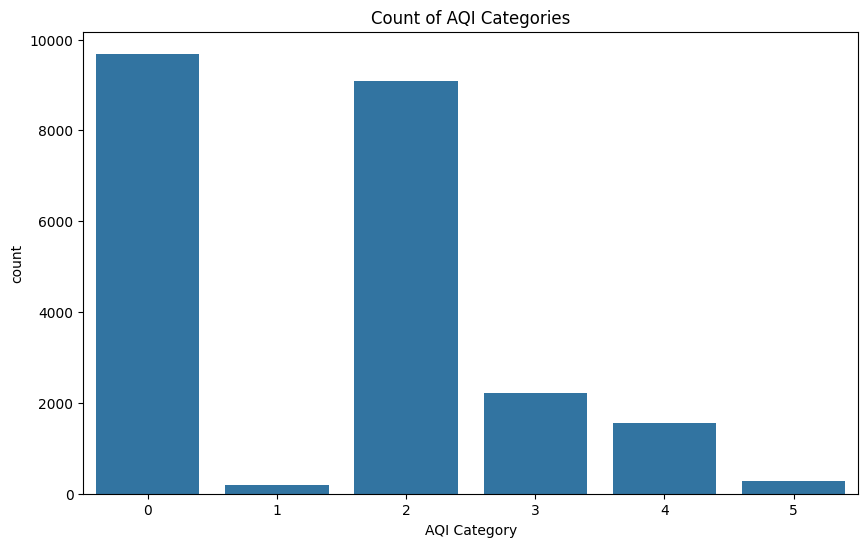

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AQI Category', data=df)
plt.title('Count of AQI Categories')
plt.show()

<ipython-input-29-dc7e95237f5d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


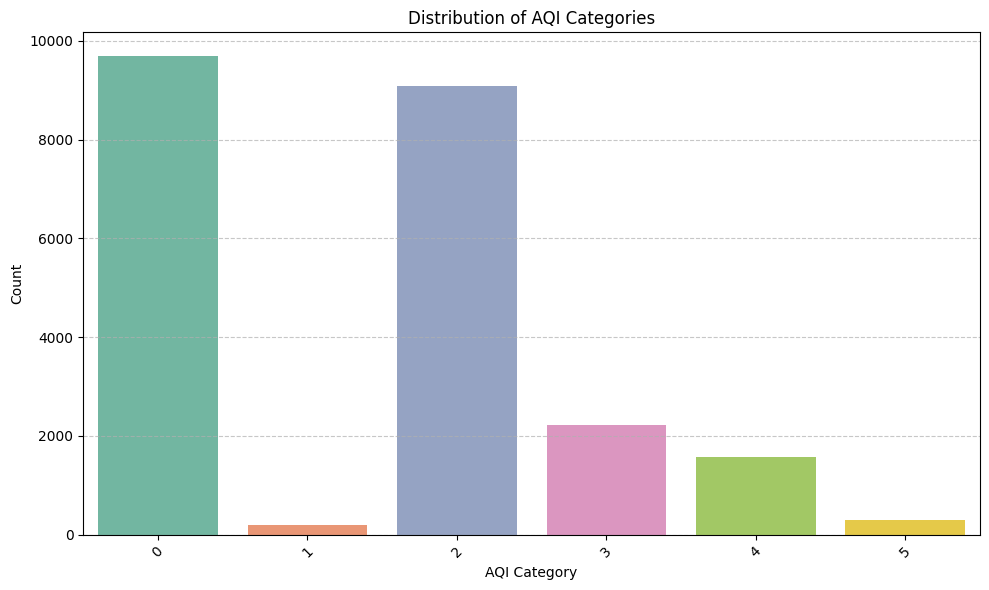

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x="AQI Category",
    data=df,
    palette="Set2"
)
plt.xticks(rotation=45)
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.title("Distribution of AQI Categories")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()